# Investigation overview of flight reports (2003-2008)
### by Jérôme d'Harveng

## Investigation Overview

> In this investigation, I wanted to look at the characteristics of cancelled flights, such as departure time, distance, time influence (as year, month or weekdays), origin and airports.


## Dataset Overview

> The data consisted of flights details from around 4.2 million flights between 2003 and 2008. Some inconsistent data had to be removed such as negative air Time.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
# Loading different needed datafiles for the exploration
df_2003 = pd.read_csv("Data/2003.csv")
print("data 2003 loaded")
df_2004 = pd.read_csv("Data/2004.csv")
print("data 2004 loaded")
df_2005 = pd.read_csv("Data/2005.csv")
print("data 2005 loaded")
df_2006 = pd.read_csv("Data/2006.csv")
print("data 2006 loaded")
df_2007 = pd.read_csv("Data/2007.csv")
print("data 2007 loaded")
df_2008 = pd.read_csv("Data/2008.csv")
print("data 2008 loaded")

data 2003 loaded
data 2004 loaded
data 2005 loaded
data 2006 loaded
data 2007 loaded
data 2008 loaded


In [3]:
# Concatenating,focus on columns of interest
study_col = ['Year','Month','DayofMonth','DayOfWeek','UniqueCarrier','FlightNum','Origin','Dest','Distance', 'DepTime','ArrTime','CRSArrTime','ActualElapsedTime','CRSElapsedTime','AirTime','ArrDelay','DepDelay','Cancelled','CancellationCode','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
df_frames = [df_2003, df_2004, df_2005, df_2006, df_2007, df_2008]
df_concatenated = pd.concat(df_frames, ignore_index=True)
df_flights = df_concatenated[study_col]

In [8]:
# Some Cleaning
df_flights = df_flights.fillna(0)
ColToInt = ['DepTime','ArrTime','ActualElapsedTime','CRSElapsedTime','AirTime','ArrDelay','DepDelay','CarrierDelay','WeatherDelay','NASDelay','SecurityDelay','LateAircraftDelay']
df_flights[ColToInt] = df_flights[ColToInt].astype('int')
df_flights = df_flights.query('AirTime >= 0')

In [23]:
# df with flights which were NOT cancelled
df_no_canc = df_flights.query('Cancelled == 0')

# df with CANCELLED flights with identified CancellationCode
df_canc = df_flights.query('Cancelled == 1 & CancellationCode != 0')

In [33]:
# Extra manipulation for polishing last visual
CancCode = {'A':'Carrier','B':'Weather','C':'NAS','D':'Security'}
MonthCode = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
OriginCode = {'ORD': 'Chicago', 'ATL':'Atlanta' , 'DFW':'Dallas', 'LGA':'New York', 'EWR':'Newark'}

# as we'll rename some variable so we take first a copy
df_canc_cp = df_canc.copy()
# focus on the 5 worst origin airports regarding amount of flight cancellations
df_canc_cp['CancellationCode'] = df_canc_cp['CancellationCode'].map(lambda item: CancCode[item])
df_canc_cp['Month'] = df_canc_cp['Month'].map(lambda item: MonthCode[item])
df_canc_cp['Origin'] = df_canc_cp['Origin'].map(lambda item: OriginCode[item] if item in OriginCode.keys() else item)
data_origin = df_canc_cp.Origin.value_counts()[0:5]

> Note that the above cells have been set as "Skip"-type slides. That means
that when the notebook is rendered as http slides, those cells won't show up.

## Distribution of departure times and distances

> The big majority of the flights in this dataset are leaving between 6am and 8pm. We see also that most flights are over shorter distances, with a spike round 250-375 miles

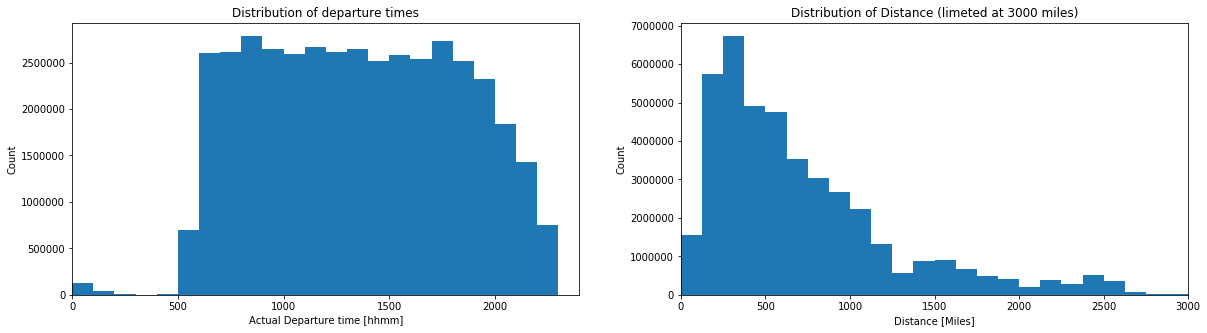

In [11]:
plt.figure(figsize = [20,5])
plt.subplot(1,2,1)
binsize = 100
bins = np.arange(0, 2400, binsize)
# We only look the DepTime for the flights that weren't cancelled
plt.hist(data = df_no_canc, x = 'DepTime', bins = bins)
plt.xlim(0,2400)
plt.xlabel('Actual Departure time [hhmm]')
plt.ylabel('Count')
plt.title('Distribution of departure times');

plt.subplot(1,2,2)
binsize = 125
bins = np.arange(0,3000+binsize, binsize)
plt.hist(data=df_flights,x='Distance',bins=bins)
plt.xlim(0,3000)
plt.xlabel('Distance [Miles]')
plt.ylabel('Count')
plt.title('Distribution of Distance (limeted at 3000 miles)');

## What is the distribution of the departure delay and what cancellation reason do we have?

> The distribution of the departure delays (in log scale), shows us that although a big part of the flights are leaving on time (spike at 1min), when having some delay most of them have round 4-5 min of delay. Besides of this we observed 2 other spikes round 12-15min and 25-30min. By having a closer look at the figures, we discovered that 25% of the flights have less than 5min of delay, and 75% of the flights have less than 36min of delay. Those figures seem acceptable, and for sure carriers put a lot of effort in trying to reduce them.


> A quick look at the cancellation codes, learns us that "carrier" and "weather" isssues are by far the main reasons for flight cancellation. And luckily for us, security is rarely the cause.

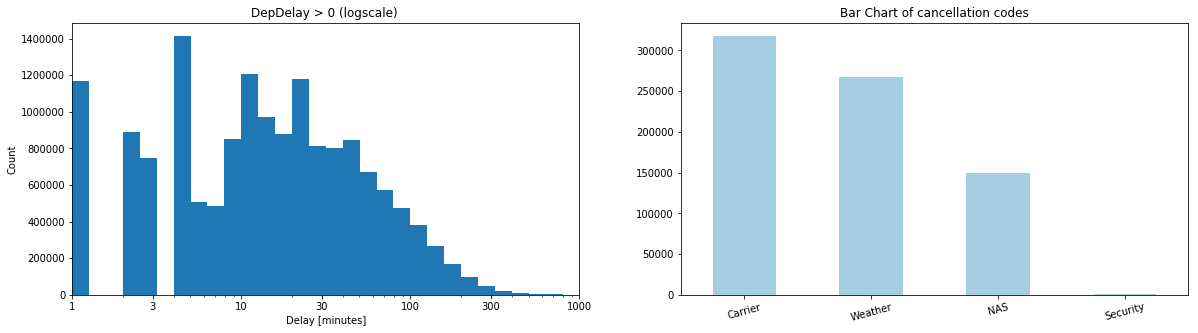

In [24]:
plt.figure(figsize = [20,5])

# Distribution of Departure Delays (focusing on >0 delays)
plt.subplot(1,2,1)
bins = 10**np.arange(0,3+0.1,0.1)
ticks = [1,3,10,30,100,300,1000]
labels = ['{}'.format(val) for val in ticks]
plt.hist(data = df_no_canc.query('DepDelay>0'), x = 'DepDelay', bins = bins)
plt.xscale('log')
plt.xlim(0,1000)
plt.xticks(ticks,labels)
plt.xlabel('Delay [minutes]')
plt.ylabel('Count')
plt.title('DepDelay > 0 (logscale) ');

# Bar plot of Cancellation Codes
plt.subplot(1,2,2)
dt_cancell_code = df_canc.groupby('CancellationCode').count().DepDelay
new_index = ['Carrier','Weather','NAS','Security']
dt_cancell_code.index = new_index
dt_cancell_code.sort_values(ascending=False).plot(x='index',y='count',kind='bar',colormap='Paired')
plt.xticks(rotation = 15)
plt.title('Bar Chart of cancellation codes');

## Is there some seasonality in the amount of cancelled flights?

> Looking at relative frequencies, 2007 seems to be the worst year with regards to the amount of cancelled flights. By visualising per month, we see that the period from December til February has the most flight cancellation, probably  linked to weather conditions, as we saw in previous section that weather is one of the most important cancellation reasons. Finally observing the weekdays, we notice a slight decrease in cancellations at week-ends.

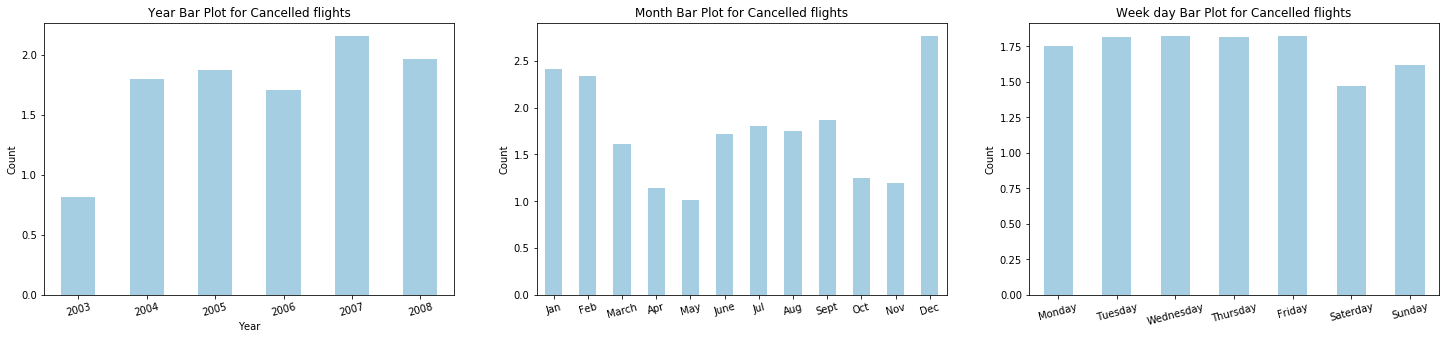

In [25]:
plt.figure(figsize = [25,5])

# Year
plt.subplot(1,3,1)
data_year = df_canc.groupby('Year').count().DepDelay
data_yr_tot = df_flights.groupby('Year').count().DepDelay
data_yr_Rel = data_year.divide(data_yr_tot)*100
data_yr_Rel.plot(x='index', y='count', kind='bar', colormap='Paired')
plt.title('Year Bar Plot for Cancelled flights')
plt.xticks(rotation = 15)
plt.ylabel('Count');

# Month
plt.subplot(1,3,2)
month_index = ['Jan','Feb','March','Apr','May','June','Jul','Aug','Sept','Oct','Nov','Dec']
data_month = df_canc.groupby('Month').count().DepDelay
data_mth_tot = df_flights.groupby('Month').count().DepDelay
data_mth_Rel = data_month.divide(data_mth_tot)*100
data_mth_Rel.index = month_index
data_mth_Rel.plot(x='index', y='count', kind='bar', colormap='Paired')
plt.title('Month Bar Plot for Cancelled flights')
plt.xticks(rotation = 15)
plt.ylabel('Count');

# DayOfWeek
plt.subplot(1,3,3)
week_index = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saterday','Sunday']
data_week = df_canc.groupby('DayOfWeek').count().DepDelay
data_wk_tot = df_flights.groupby('DayOfWeek').count().DepDelay
data_wk_Rel = data_week.divide(data_wk_tot)*100
data_wk_Rel.index = week_index
data_wk_Rel.plot(x='index', y='count', kind='bar', colormap='Paired')
plt.title('Week day Bar Plot for Cancelled flights')
plt.xticks(rotation = 15)
plt.ylabel('Count');

## Closer look to the 5 cities having the airports with most cancelled flights
> Those 5 cities in decreasing order (most cancelled flights towards less) are : Chicago, Atlanta, Dallas, New York and Newark.
We saw earlier that in general December till February is the worst period with regards to the amount of cancelled flights. This is also visible for those specific 5 airports. We see also that in those months (vs the rest of the year), that weather is the most important factor for cancellation.


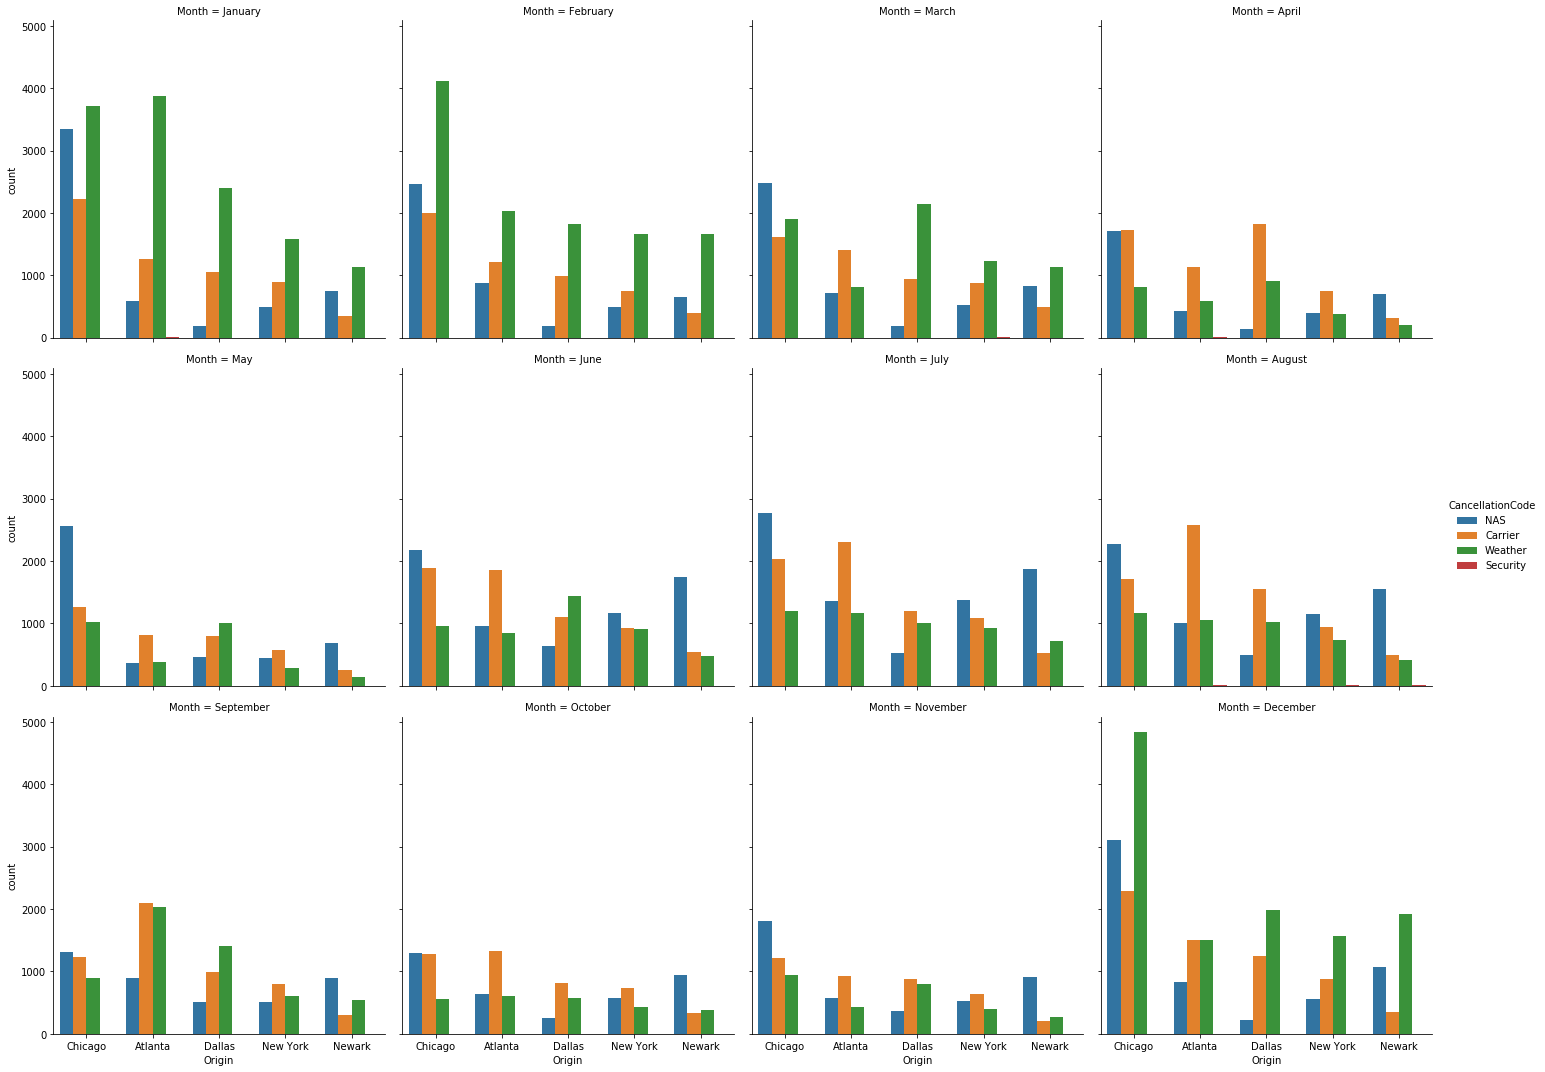

In [42]:
city_filter = data_origin.index
mask_city = df_canc_cp.Origin.isin(city_filter)
data_origin_mask = df_canc_cp[mask_city]
# in order to keep the same order decreasing order in Origin cities as determined in the Univariate exploration
ordered_origin = pd.api.types.CategoricalDtype(ordered = True,categories = city_filter)
data_origin_mask['Origin'] = data_origin_mask['Origin'].astype(ordered_origin)
month_order = ['January','February','March','April','May','June','July','August','September','October','November','December']
ordered_originM = pd.api.types.CategoricalDtype(ordered = True,categories = month_order)
data_origin_mask['Month'] = data_origin_mask['Month'].astype(ordered_originM)


g = sb.factorplot("Origin",hue = 'CancellationCode',data=data_origin_mask,col='Month',col_wrap= 4,kind="count")